In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt


In [ ]:
# Data Augmentation - Increase diversity in training data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
# Load the training and test datasets
train_dataset = datasets.ImageFolder(root='train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='test', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

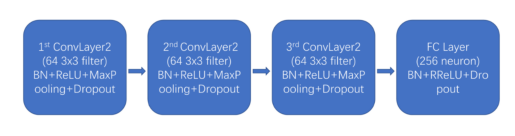

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image
img = mpimg.imread(r'C:\Users\Apurva\OneDrive\Pictures\Screenshots\Screenshot 2024-11-12 212049.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [ ]:
# Define the CNN model with Batch Normalization and Dropout layers
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 7)

    def forward(self, x):
        x = self.pool(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool(self.bn2(torch.relu(self.conv2(x))))
        x = self.pool(self.bn3(torch.relu(self.conv3(x))))
        x = x.view(-1, 128 * 6 * 6)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# Instantiate the model
model = CNNModel()
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Define the loss function and optimizer with weight decay for regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [ ]:
def train_model(model, train_loader, test_loader, optimizer, scheduler, num_epochs=20):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_accuracy = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

C:\Users\Apurva\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Train Loss: 1.7019, Train Accuracy: 33.20%, Test Loss: 1.4828, Test Accuracy: 41.15%
Epoch [2/20], Train Loss: 1.4956, Train Accuracy: 42.18%, Test Loss: 1.3698, Test Accuracy: 46.81%
Epoch [3/20], Train Loss: 1.4013, Train Accuracy: 45.97%, Test Loss: 1.2921, Test Accuracy: 51.17%
Epoch [4/20], Train Loss: 1.3529, Train Accuracy: 48.38%, Test Loss: 1.2121, Test Accuracy: 53.30%
Epoch [5/20], Train Loss: 1.3124, Train Accuracy: 50.16%, Test Loss: 1.1806, Test Accuracy: 54.92%
Epoch [6/20], Train Loss: 1.2817, Train Accuracy: 51.64%, Test Loss: 1.1477, Test Accuracy: 55.48%
Epoch [7/20], Train Loss: 1.2532, Train Accuracy: 52.46%, Test Loss: 1.1536, Test Accuracy: 54.79%
Epoch [8/20], Train Loss: 1.2243, Train Accuracy: 54.01%, Test Loss: 1.1743, Test Accuracy: 55.41%
Epoch [9/20], Train Loss: 1.2160, Train Accuracy: 54.21%, Test Loss: 1.1212, Test Accuracy: 57.12%
Epoch [10/20], Train Loss: 1.1982, Train Accuracy: 54.83%, Test Loss: 1.1055, Test Accuracy: 58.07%
Epoch [11

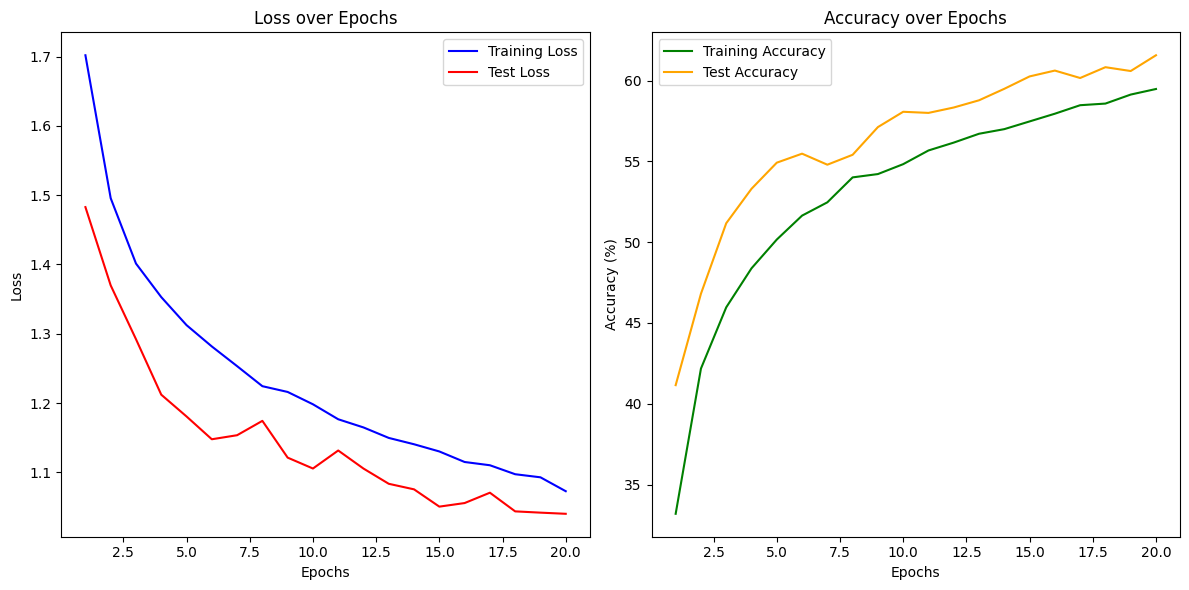

In [1]:
# Evaluate on the test set
        model.eval()
        correct, total, test_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_losses.append(test_loss / len(test_loader))
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        # Adjust learning rate based on the test loss
        scheduler.step(test_loss / len(test_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies

# Run the training
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, optimizer, scheduler, num_epochs=20
)

# Plot Loss and Accuracy Graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='green')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()
